In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
%load_ext autoreload
%autoreload 2

In [2]:
POKEMON_FILE='pokemon.csv'
COMBATS_FILE='combats.csv'

## Question 1: Exploring the data

In [3]:
pokemon = pd.read_csv(POKEMON_FILE)
combats = pd.read_csv(COMBATS_FILE)

### Task 1

In [4]:
pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [5]:
#Classes
pokemon['Class 1'].append(pokemon['Class 2']).dropna().unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

### Task 2

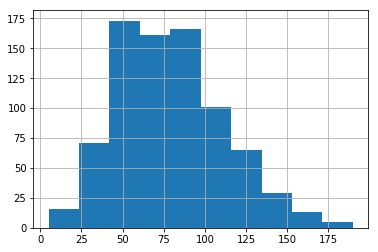

In [6]:
pokemon['Attack'].hist()

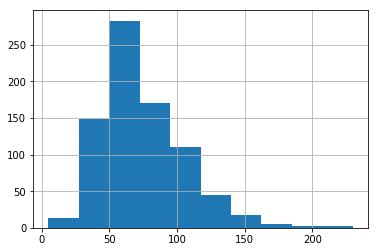

In [7]:
pokemon['Defense'].hist()

In [8]:
pokemon['AD_Ratio'] = pokemon['Attack']/pokemon['Defense']
pokemonWithRatio = pokemon.sort_values('AD_Ratio')

In [9]:
lowestRatio = pokemonWithRatio.head(3)
highestRatio = pokemonWithRatio.tail(3)

In [10]:
lowestRatio[['Name','AD_Ratio']]

,Name,AD_Ratio
230,Shuckle,0.043478
139,Magikarp,0.181818
484,Bronzor,0.279070


In [11]:
highestRatio[['Name','AD_Ratio']].sort_values('AD_Ratio', ascending=False)

,Name,AD_Ratio
429,DeoxysAttack Forme,9.00
347,Carvanha,4.50
19,Mega Beedrill,3.75


In [12]:
#top10
combats['Winner'].value_counts().head(10).reset_index().merge(pokemon[['Name', 'pid']], left_on='index', right_on='pid', how='inner')['Name']

0                Mewtwo
1            Aerodactyl
2             Infernape
3               Jirachi
4    Deoxys Speed Forme
5               Slaking
6               Murkrow
7            Mega Absol
8         Mega Houndoom
9       Mega Aerodactyl
Name: Name, dtype: object

### Task 3

In [13]:
grass_pokemon_mean_Attack = pokemon[(pokemon['Class 1'] == 'Grass') | (pokemon['Class 2'] == 'Grass')]['Attack'].mean()
rock_pokemon_mean_Attack = pokemon[(pokemon['Class 1'] == 'Rock') | (pokemon['Class 2'] == 'Rock')]['Attack'].mean()

In [14]:
rock_pokemon_mean_Attack > grass_pokemon_mean_Attack

True

### Task 4

In [15]:
#spark_combats.select('Winner').count().orderBy('count', ascending=False).join(spark_pokemon.select(['Name', 'pid']), 'Winner'=='pid', 'inner').select('Name')

## Question 2: Prediction

### Preprocessing

In [16]:
#if a pokemon belongs in two classes, add one row for each class in the trainning set

#create two rows per 2-class pokemon
pokemonFlat = pokemon.drop(['Class 2'], axis=1).rename(columns = {'Class 1':'Class'}).append(pokemon.drop(['Class 1'], axis=1).rename(columns = {'Class 2':'Class'}).dropna())

In [17]:
pokemonFlat[pokemonFlat.isnull().any(axis=1)]

,pid,Name,Class,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,AD_Ratio
62,63,NaN,Fighting,65,105,60,60,70,95,False,1.75


In [18]:
#dropping pokemon without name
pokemonFlat = pokemonFlat.dropna()
#no NaNs
pokemonFlat.isnull().values.any()

False

In [19]:
#transform Categorical feature to Numerical
le = preprocessing.LabelEncoder()
le.fit(pokemonFlat['Class'].unique())
pokemonFlat['Class'] = le.transform(pokemonFlat['Class'])

In [20]:
#creating training set
combats['First_winner'] = combats['First_pokemon'] == combats['Winner']
training_set = combats.merge(pokemonFlat, left_on='First_pokemon', right_on='pid', how='inner')
training_set = training_set.merge(pokemonFlat, left_on='Second_pokemon', right_on='pid', how='inner', suffixes=('_1', '_2'))
training_set = training_set.drop(['First_pokemon', 'Second_pokemon', 'Winner', 'pid_1', 'Name_1', 'pid_2', 'Name_2'], axis=1)
training_set_X = training_set.drop('First_winner', axis=1)
training_set_y = training_set['First_winner']

### Training Model

In [21]:
X_train, X_test, y_train, y_test = train_test_split(training_set_X, training_set_y, train_size=0.9, test_size=0.1, random_state=27)

In [22]:
#grid search
best_score = 0.0
for n_estimators in [10, 25, 50, 100]:
    for max_depth in [2, 4, 10]:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=4)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_params = (n_estimators, max_depth)
print('Best parameters:', best_params)
print('Best score:', best_score)

Best parameters: (50, 10)
Best score: 0.940584612716


### Cross-validation

In [23]:
#cross validate to use the full dataset for training not only the 90% (5-fold)
cv = ShuffleSplit(n_splits=5, train_size=0.9, test_size=0.1, random_state=0)

#grid search
best_score = 0.0
for n_estimators in [10, 25, 50, 100]:
    for max_depth in [2, 4, 10]:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=4)
        score = cross_val_score(clf, training_set_X, training_set_y, cv=cv).mean()
        if score > best_score:
            best_score = score
            best_params = (n_estimators, max_depth)
print('Best parameters:', best_params)
print('Best score:', best_score)


Best parameters: (100, 10)
Best score: 0.940636655391


### Feature Importance

Feature ranking:
1. feature Speed_1 (0.370284)
2. feature Speed_2 (0.347640)
3. feature Attack_1 (0.038533)
4. feature Attack_2 (0.036093)
5. feature Sp. Atk_1 (0.031854)
6. feature Sp. Atk_2 (0.028786)
7. feature AD_Ratio_2 (0.020829)
8. feature AD_Ratio_1 (0.018944)
9. feature HP_1 (0.017814)
10. feature HP_2 (0.017484)
11. feature Sp. Def_1 (0.015145)
12. feature Sp. Def_2 (0.014764)
13. feature Defense_2 (0.011840)
14. feature Defense_1 (0.011337)
15. feature Legendary_2 (0.005385)
16. feature Legendary_1 (0.004973)
17. feature Class_1 (0.004293)
18. feature Class_2 (0.004000)


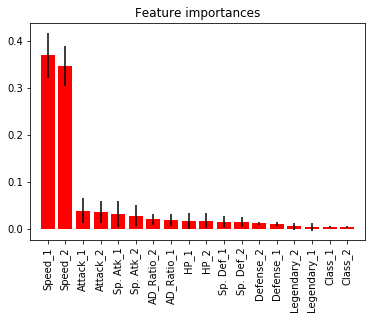

In [24]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=4)
clf.fit(training_set_X, training_set_y)

#source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(training_set_X.shape[1]):
    print("%d. feature %s (%f)" % (f+1, training_set_X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_set_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_set_X.shape[1]), training_set_X.columns[indices],rotation='vertical')
plt.xlim([-1, training_set_X.shape[1]])
plt.show()


## Question 3: Ranking

### Task 1

In [101]:
#convert combats to pokemon(index), count(battles), count(wins)
combats['Second_winner'] = ~combats['First_winner'] 
matches = combats[['First_pokemon','First_winner']].rename(columns = {'First_pokemon':'pokemon', 'First_winner': 'win'})
matches = matches.append(combats[['Second_pokemon','Second_winner']].rename(columns = {'Second_pokemon':'pokemon', 'Second_winner': 'win'}))
battles = matches.groupby('pokemon').count().rename(columns = {'win':'count'})
wins = matches[matches['win']==True].groupby('pokemon').count().rename(columns = {'win':'wins'})
battles = battles.join(wins)

In [102]:
battles[battles.isnull().any(axis=1)]

,count,wins
pokemon,,
231,135,NaN


In [103]:
battles = battles.fillna(0.0)
battles.isnull().values.any()

False

In [104]:
#top10
battles['ratio'] = battles['wins']/battles['count']
top10ratio = battles['ratio'].sort_values(ascending=False).head(10).reset_index().merge(pokemon[['Name', 'pid']], left_on='pokemon', right_on='pid', how='inner')['Name']
top10ratio

0             Mega Aerodactyl
1                     Weavile
2      Tornadus Therian Forme
3               Mega Beedrill
4                  Aerodactyl
5                Mega Lopunny
6                    Greninja
7    Meloetta Pirouette Forme
8               Mega Mewtwo Y
9               Mega Sharpedo
Name: Name, dtype: object

### Task 2

In [105]:
#dataframe with index (first_pokemon, second_pokemon) and columns wins/losses
battlesWins =   combats[combats['First_winner']==True].groupby(['First_pokemon', 'Second_pokemon'])[['First_winner']].count().rename(columns = {'First_winner':'wins'})
battlesLosses = combats[combats['First_winner']==False].groupby(['First_pokemon', 'Second_pokemon'])[['First_winner']].count().rename(columns = {'First_winner':'losses'})
battles = pd.concat([battlesWins, battlesLosses])
battles = battles.fillna(0.0)
battles['majorityWins'] = battles['wins']>battles['losses']
battles = battles[battles['majorityWins']==True][['majorityWins']]

In [106]:
G = np.zeros([pokemon.shape[0], pokemon.shape[0]])
for (p1, p2), row in battles.iterrows():
    G[p1-1, p2-1] = 1
A = G + np.linalg.matrix_power(G, 2)

### Tasks 3, 4, 5

In [120]:
#top10
indices = pd.DataFrame(A.sum(axis=0).argsort()[-10:][::-1])
top10dominance = pokemon.merge(indices, left_on='pid', right_on=0)['Name']
top10dominance

0                    Golbat
1                 Vileplume
2             Mega Alakazam
3                  Ursaring
4                   Linoone
5                    Dustox
6                   Azurill
7                Mega Absol
8                  Accelgor
9    Aegislash Shield Forme
Name: Name, dtype: object

In [123]:
top10dominance.isin(top10ratio).any() | top10ratio.isin(top10dominance).any()

False